In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load CSV(s)
data_dir = '../data'
files = [f for f in os.listdir(data_dir) if f.endswith('.csv') and 'E0' in f]

dfs = []
for file in files:
    df = pd.read_csv(os.path.join(data_dir, file))
    dfs.append(df)

# Combine into one DataFrame
matches = pd.concat(dfs, ignore_index=True)

# Preview data
print(f"Dataset shape: {matches.shape}")
matches.head()


Dataset shape: (1140, 106)


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,13/08/2021,20:00,Brentford,Arsenal,2,0,H,1,0,...,1.62,0.50,1.75,2.05,1.81,2.13,2.05,2.17,1.80,2.09
1,E0,14/08/2021,12:30,Man United,Leeds,5,1,H,1,0,...,2.25,-1.00,2.05,1.75,2.17,1.77,2.19,1.93,2.10,1.79
2,E0,14/08/2021,15:00,Burnley,Brighton,1,2,A,1,0,...,1.62,0.25,1.79,2.15,1.81,2.14,1.82,2.19,1.79,2.12
3,E0,14/08/2021,15:00,Chelsea,Crystal Palace,3,0,H,2,0,...,1.94,-1.50,2.05,1.75,2.12,1.81,2.16,1.93,2.06,1.82
4,E0,14/08/2021,15:00,Everton,Southampton,3,1,H,0,1,...,1.67,-0.50,2.05,1.88,2.05,1.88,2.08,1.90,2.03,1.86


In [54]:
# Keep only relevant columns
columns_to_keep = [
    'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
    'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR'
]

matches = matches[[col for col in columns_to_keep if col in matches.columns]]

# Rename columns for clarity
matches.rename(columns={
    'FTHG': 'HomeGoals',
    'FTAG': 'AwayGoals',
    'FTR': 'Result',
    'HS': 'HomeShots', 'AS': 'AwayShots',
    'HST': 'HomeShotsTarget', 'AST': 'AwayShotsTarget',
    'HC': 'HomeCorners', 'AC': 'AwayCorners',
    'HF': 'HomeFouls', 'AF': 'AwayFouls',
    'HY': 'HomeYellows', 'AY': 'AwayYellows',
    'HR': 'HomeReds', 'AR': 'AwayReds'
}, inplace=True)

# Convert 'Date' to datetime
matches['Date'] = pd.to_datetime(matches['Date'], dayfirst=True)


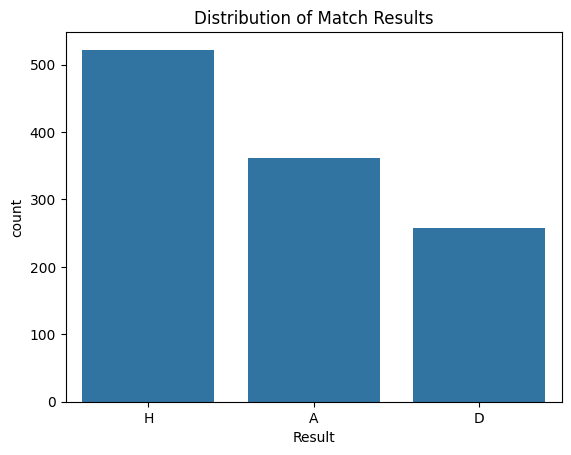

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Result', data=matches)
plt.title('Distribution of Match Results')
plt.show()


In [56]:
# Create target column: 1 if home team won, else 0
matches['HomeWin'] = matches['Result'].apply(lambda x: 1 if x == 'H' else 0)
matches['HomeWin'].value_counts()

HomeWin
0    618
1    522
Name: count, dtype: int64

In [57]:
# Feature columns
features = [
    'HomeShots', 'AwayShots',
    'HomeShotsTarget', 'AwayShotsTarget',
    'HomeCorners', 'AwayCorners',
    'HomeFouls', 'AwayFouls',
    'HomeYellows', 'AwayYellows',
    'HomeReds', 'AwayReds'
]

matches_model = matches.dropna(subset=features + ['HomeWin'])

X = matches_model[features]
y = matches_model['Result']


In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt


In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [60]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

Logistic Regression Accuracy: 0.6140350877192983
              precision    recall  f1-score   support

           A       0.60      0.72      0.65        68
           D       0.60      0.10      0.17        61
           H       0.62      0.86      0.72        99

    accuracy                           0.61       228
   macro avg       0.61      0.56      0.52       228
weighted avg       0.61      0.61      0.55       228



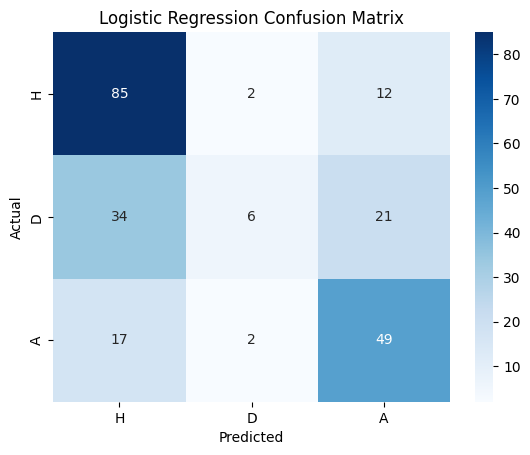

In [61]:
labels = ['H', 'D', 'A']  # Home Win, Draw, Away Win


y_pred = model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.show()


In [62]:
# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


Random Forest Accuracy: 0.5570175438596491
              precision    recall  f1-score   support

           A       0.56      0.71      0.62        68
           D       0.22      0.03      0.06        61
           H       0.58      0.78      0.66        99

    accuracy                           0.56       228
   macro avg       0.45      0.51      0.45       228
weighted avg       0.48      0.56      0.49       228



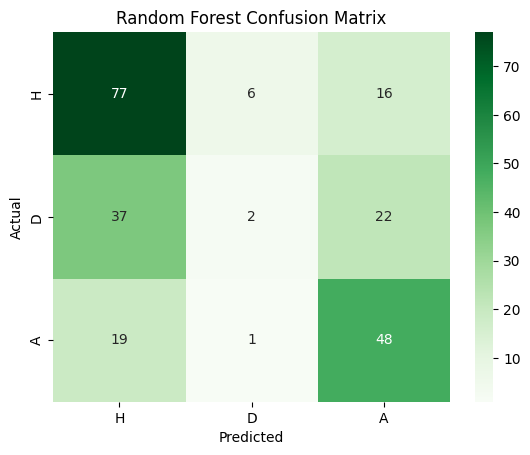

In [63]:
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf, labels=labels)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()


In [64]:
import joblib

# Save to disk
joblib.dump(rf_model, '../models/random_forest_model.pkl')
joblib.dump(model, '../models/logistic_regression_model.pkl')
joblib.dump(features, '../models/features_used.pkl')



['../models/features_used.pkl']

## Model Summary

- Logistic Regression Accuracy: 0.61%
- Random Forest Accuracy: 0.55%
- Team form was tested but did not improve performance

Saved model: `random_forest_model.pkl`
